In [1]:
import pandas as pd
import numpy as np
import random
from rdkit import Chem
from snn_model import get_loss_fn
import torch
from torch.utils.data import TensorDataset, DataLoader
from snntorch import spikegen, surrogate
import matplotlib.pyplot as plt
from utils import load_dataset_df, smile_to_fp, data_splitter, get_spiking_net, make_filename
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score
from csnn_model import CSNNet, get_prediction_fn, bias

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\knsve\Desktop\MEI\Tese\torch\snn_venv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-geometri

In [2]:
#!pip install pandas numpy rdkit torch snntorch matplotlib scikit-learn deepchem pubchempy

#### Load DataFrame

In [3]:
files = ['tox21.csv','sider.csv', 'BBBP.csv']
dt_file = files[1]
dirname = dt_file.removesuffix('.csv')

df, targets = load_dataset_df(filename=dt_file)

for t in targets:
    df_temp = df[[t, 'smiles']].dropna()
    class_counts = df[t].count()
    class_sum = df[t].sum()
    print(t, class_counts, round(class_sum/class_counts, 2)) 


Hepatobiliary disorders 1427 0.52
Metabolism and nutrition disorders 1427 0.7
Product issues 1427 0.02
Eye disorders 1427 0.61
Investigations 1427 0.81
Musculoskeletal and connective tissue disorders 1427 0.7
Gastrointestinal disorders 1427 0.91
Social circumstances 1427 0.18
Immune system disorders 1427 0.72
Reproductive system and breast disorders 1427 0.51
Neoplasms benign, malignant and unspecified (incl cysts and polyps) 1427 0.26
General disorders and administration site conditions 1427 0.91
Endocrine disorders 1427 0.23
Surgical and medical procedures 1427 0.15
Vascular disorders 1427 0.78
Blood and lymphatic system disorders 1427 0.62
Skin and subcutaneous tissue disorders 1427 0.92
Congenital, familial and genetic disorders 1427 0.18
Infections and infestations 1427 0.7
Respiratory, thoracic and mediastinal disorders 1427 0.74
Psychiatric disorders 1427 0.71
Renal and urinary disorders 1427 0.64
Pregnancy, puerperium and perinatal conditions 1427 0.09
Ear and labyrinth disorde

In [4]:
if dirname == 'tox21':
    # SR-ARE
    target_name = targets[7]
    # SR-MMP
elif dirname == 'sider':
    #Hepatobiliary disorders 1427 samples, 0.52 class ratio
    target_name = targets[0]
else:
    target_name = targets[0]
    
df = df[[target_name, 'smiles']].dropna()

#### SMILE to Fingerprint

In [5]:
fp_types = [['morgan', 1024], ['maccs', 167], ['RDKit', 1024], ['pubchem', 881]]
mix = False
fp_type, num_bits = fp_types[0]
if mix and fp_type == 'RDKit':
    num_bits = 512
fp_config = {"fp_type": fp_type,
             "num_bits": num_bits,
             "radius": 2,
             "fp_type_2": fp_types[0][0],
             "num_bits_2": 1024 - num_bits,
             "mix": mix,
             }
dim_2 = True
print(fp_type, '-', num_bits)
if mix:
   print(fp_config['fp_type_2'], '-', fp_config['num_bits_2'])
if dim_2: print("2D FP")

morgan - 1024
2D FP


In [6]:
dtype = torch.float32
split = "scaffold"
dataset = None

if dirname != 'BBBP':
    split = "random"

    fp_array, target_array = smile_to_fp(df, fp_config=fp_config, target_name=target_name)
    # Create Torch Dataset
    fp_tensor = torch.tensor(fp_array, dtype=dtype)
    print(fp_tensor.size())
    target_tensor = torch.tensor(target_array, dtype=dtype).long()
    if dim_2:
        fp_tensor = fp_tensor.view(-1, 32, 32)
        print(fp_tensor.size())
    dataset = TensorDataset(fp_tensor, target_tensor)

[18:37:42] WARNING: not removing hydrogen atom without neighbors
[18:37:42] WARNING: not removing hydrogen atom without neighbors
[18:37:42] WARNING: not removing hydrogen atom without neighbors
[18:37:42] WARNING: not removing hydrogen atom without neighbors
[18:37:42] WARNING: not removing hydrogen atom without neighbors
[18:37:42] WARNING: not removing hydrogen atom without neighbors
[18:37:42] WARNING: not removing hydrogen atom without neighbors
[18:37:42] WARNING: not removing hydrogen atom without neighbors
[18:37:43] WARNING: not removing hydrogen atom without neighbors
[18:37:43] WARNING: not removing hydrogen atom without neighbors
[18:37:43] WARNING: not removing hydrogen atom without neighbors
[18:37:43] WARNING: not removing hydrogen atom without neighbors
[18:37:43] WARNING: not removing hydrogen atom without neighbors


torch.Size([1427, 1024])
torch.Size([1427, 32, 32])


In [7]:
print(fp_tensor.size())

torch.Size([1427, 32, 32])


#### Loss Function

In [8]:
from sklearn.utils.class_weight import compute_class_weight

loss_types = ['ce_mem', 'rate_loss', 'count_loss', 'temporal_loss', 'bce_loss']
loss_type = loss_types[2]
print(loss_type)


count_loss


#### Train Loop

In [9]:
net_types = ["SNN", "DSNN", "CSNN"]
net_type = net_types[2]
slope = 10
#spike_grad = surrogate.fast_sigmoid(slope=slope)
spike_grad = None
beta = 0.95 #experimentar 0.7

net_config = {"input_size": 1024 if fp_config['mix'] else num_bits,
              "2d": dim_2,
              "num_hidden": 512,
              "num_hidden_l2": 256,
              "time_steps": 10,
              "spike_grad": spike_grad,
              "slope": None if not spike_grad else slope, #spike_grad.__closure__[0].cell_contents,
              "beta": beta,
              "encoding": 'rate' if loss_type != 'temporal_loss' else 'ttfs',
              "bias": bias,
              "out_num": 2
              }
pop_coding = net_config['out_num'] > 2

In [10]:
lr=1e-4 #1e-6 default for 1000 epochs. csnn requires higher
iterations = 30
weight_decay = 0 # 1e-5
optim_type = 'Adam'
#optim_type = 'SGD'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 16 #16, 8
train_config = {"num_epochs": 1000,
                "batch_size": batch_size,
                "device": device,
                "loss_type": loss_type,
                "loss_fn": None,
                'dtype': dtype,
                'num_steps': net_config['time_steps'],
                'val_net': None,
                'prediction_fn': get_prediction_fn(encoding=net_config['encoding'], pop_coding=pop_coding),
                }
drop_last = net_type == "CSNN"
pin_memory = device == "cuda"
save_csv = False
save_models = False
results = [[], [], [], [], [], []]

cuda


In [11]:
print("-----Configuration-----")
print(net_config)
print(train_config)

-----Configuration-----
{'input_size': 1024, '2d': True, 'num_hidden': 512, 'num_hidden_l2': 256, 'time_steps': 10, 'spike_grad': None, 'slope': None, 'beta': 0.95, 'encoding': 'rate', 'bias': True, 'out_num': 2}
{'num_epochs': 1000, 'batch_size': 16, 'device': device(type='cuda'), 'loss_type': 'count_loss', 'loss_fn': None, 'dtype': torch.float32, 'num_steps': 10, 'val_net': None, 'prediction_fn': <function prediction_spk_rate at 0x0000024833FE8D30>}


In [12]:
from rdkit import RDLogger

# Disable RDKit logging for the scaffold meeting
RDLogger.DisableLog('rdApp.*')


In [13]:
def calc_metrics(metrics_list, all_targets, all_preds):
    accuracy = accuracy_score(all_targets, all_preds)
    auc_roc = roc_auc_score(all_targets, all_preds)
    tn, fp, fn, tp = confusion_matrix(all_targets, all_preds).ravel()
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    f1 = f1_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)
    
    metrics_list[0].append(accuracy)
    metrics_list[1].append(auc_roc)
    metrics_list[2].append(sensitivity)
    metrics_list[3].append(specificity)
    metrics_list[4].append(f1)
    metrics_list[5].append(precision)
    

In [14]:
import time
times = []

In [ ]:
for iter in range(iterations):
    print(f"Iteration:{iter + 1}/{iterations}")
    seed = iter + 1
    print(f"Seed:{seed}")
    random.seed(seed)

    net, train_net, val_net, test_net = get_spiking_net(net_type, net_config)
    net = net.to(device)
    train_config['val_net'] = val_net
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
    #optimizer = torch.optim.AdamW(net.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
    #optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_config['num_epochs'])
    #optimizer = torch.optim.Adamax(params, lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    #train_config["scheduler"] = scheduler

    # DATA SPLIT
    train, val, test = data_splitter(df, target_name, split=split, dataset=dataset, fp_config=fp_config, seed=seed, dtype=dtype)
    _, train_label = train[:]
    _, val_label = val[:]
    _, test_label = test[:]
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, drop_last=drop_last)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, pin_memory=pin_memory)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, pin_memory=pin_memory)

    # LOSS FN
    class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1], dtype=np.int8), y=np.array(train_label, dtype=np.int8))
    #class_weights[0] = class_weights[0]/2 
    #class_weights[0] = class_weights[0]*2
    class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)
    train_config["loss_fn"] = get_loss_fn(loss_type=loss_type, class_weights=class_weights, pop_coding=pop_coding)


    # TRAINING
    start_time = time.time()
    net, loss_hist, val_acc_hist, val_auc_hist, net_list = train_net(net=net, optimizer=optimizer, train_loader=train_loader, val_loader=val_loader, train_config=train_config, net_config=net_config)
    end_time = time.time()

    train_time = end_time - start_time
    times.append(train_time)
    print()
    print(f"Time: {train_time:.4f} seconds")
    # TESTING
    model = net
    best_test_auc = 0
    best_epoch = 0
    for index, model_dict in enumerate(net_list):
        model.load_state_dict(model_dict)
        model.to(device)
        all_preds2, all_targets2 = test_net(model, device, test_loader, train_config)
        auc_roc_test = roc_auc_score(all_targets2, all_preds2)
        if auc_roc_test > best_test_auc:
            best_test_auc, best_epoch = (auc_roc_test, index)

    print('-- best epoch:', best_epoch,'--best auc:', best_test_auc)
    model.load_state_dict(net_list[best_epoch])
    if save_models:
        filename = make_filename(dirname, target_name, net_type, fp_config, lr, weight_decay, optim_type, net_config, train_config, model, model = True)
        model_name = filename.removesuffix('.csv') + f"seed-{seed}" +'.pth'
        torch.save(model.state_dict(), model_name)
    all_preds, all_targets = test_net(model, device, test_loader, train_config)
    calc_metrics(results, all_preds=all_preds, all_targets=all_targets)

Iteration:1/30
Seed:1
Epoch:Epoch:10|auc:0.532843137254902|loss:0.6960698366165161
Epoch:20|auc:0.5401960784313725|loss:0.6568577289581299
Epoch:30|auc:0.553235294117647|loss:0.6006346940994263
Epoch:40|auc:0.5272549019607843|loss:0.6681240797042847
Epoch:50|auc:0.5739215686274509|loss:0.7082077860832214
Epoch:60|auc:0.5886274509803922|loss:0.7141621112823486
Epoch:70|auc:0.6053921568627452|loss:0.6297119855880737
Epoch:80|auc:0.5973529411764705|loss:0.43493932485580444
Epoch:90|auc:0.5913725490196078|loss:0.6827043294906616
Epoch:100|auc:0.6221568627450982|loss:0.548913836479187
Epoch:110|auc:0.5552941176470588|loss:0.5460983514785767
Epoch:120|auc:0.574607843137255|loss:0.43693143129348755
Epoch:130|auc:0.6152941176470589|loss:0.7464476823806763
Epoch:140|auc:0.6141176470588235|loss:0.5284169912338257
Epoch:150|auc:0.6607843137254903|loss:0.587266206741333
Epoch:160|auc:0.6093137254901961|loss:0.23094551265239716
Epoch:170|auc:0.6141176470588235|loss:0.6812984943389893
Epoch:180|auc:

In [ ]:
print(sum(times)/len(times))

776.3974039554596


#### Smoothed Loss

C:\Users\knsve\AppData\Local\Temp\ipykernel_25520\4265383385.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


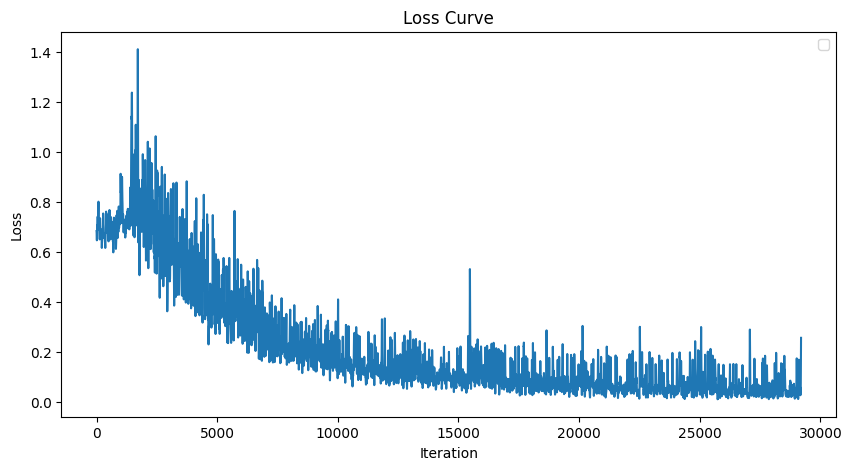

In [ ]:
#from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
#from statsmodels.nonparametric.smoothers_lowess import lowess

#print(loss_hist[len(loss_hist) - 5:len(loss_hist)])

fig = plt.figure(facecolor="w", figsize=(10, 5))
#plt.plot(np.convolve(loss_hist, np.ones(30)/30, mode='valid'))
#plt.plot(savgol_filter(loss_hist, window_length=100, polyorder=3))
#plt.plot(lowess(loss_hist, np.arange(len(loss_hist)), frac=0.1)[:, 1])
plt.plot(gaussian_filter1d(loss_hist, sigma=6))
#plt.plot(loss_hist)
#plt.axhline(y=1, color='r', linestyle='--', label='y = 1')
plt.title("Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

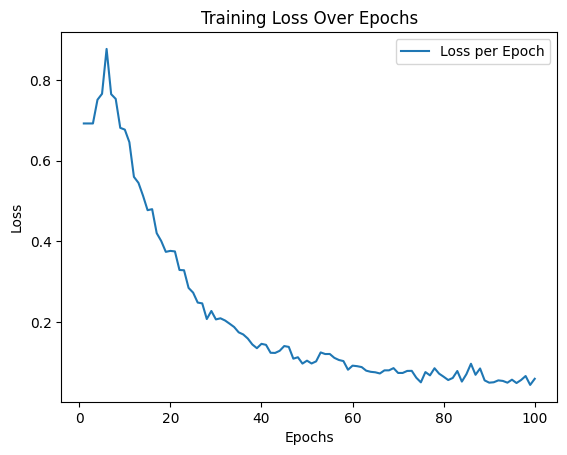

In [ ]:
num_epochs = train_config['num_epochs']
num_minibatches_per_epoch = len(loss_hist) // num_epochs

# Create x-axis values in terms of epochs
epochs = np.linspace(1, num_epochs, len(loss_hist))
epoch_losses = np.array(loss_hist).reshape(num_epochs, num_minibatches_per_epoch).mean(axis=1)

plt.plot(range(1, num_epochs + 1), epoch_losses, label="Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

C:\Users\knsve\AppData\Local\Temp\ipykernel_25520\1552820167.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


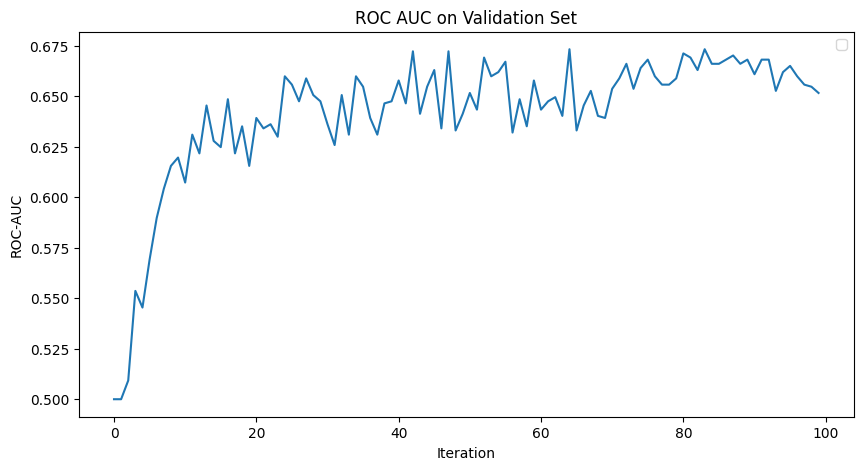

In [ ]:
# Validation Set
fig = plt.figure(facecolor="w", figsize=(10, 5))

#plt.plot(gaussian_filter1d(val_auc_hist, sigma=6))
plt.plot(val_auc_hist)
plt.title("ROC AUC on Validation Set")
plt.xlabel("Iteration")
plt.ylabel("ROC-AUC")
plt.legend()
plt.show()

#### Save Metrics

In [ ]:
metrics_np = np.zeros(12)

for i, metric in enumerate(results):
    metrics_np[i*2] = np.round(np.mean(metric), 3)
    metrics_np[i*2+1] = np.round(np.std(metric), 3)

# Print Results
print(f"Accuracy:  {metrics_np[0]:.3f} ± {metrics_np[1]:.3f}")
print(f"AUC ROC: {metrics_np[2]:.3f} ± {metrics_np[3]:.3f}")
print(f"Sensitivity: {metrics_np[4]:.3f} ± {metrics_np[5]:.3f}")
print(f"Specificity: {metrics_np[6]:.3f} ± {metrics_np[7]:.3f}")

metric_names = ['Acc', 'AUC', 'Sn', 'Sp', 'F1', 'Precision']
metrics_np = metrics_np.reshape(1, -1)
columns = []
for name in metric_names:
    columns.extend([f'Mean {name}', f'Std {name}'])


df_metrics = pd.DataFrame(metrics_np, columns=columns)
num_hidden = net_config['num_hidden']
time_steps = train_config['num_steps']
num_epochs = train_config['num_epochs']

# TODO: Add neuron thresholds to name
filename = make_filename(dirname, target_name, net_type, fp_config, lr, weight_decay, optim_type, net_config, train_config, model)
if save_csv: df_metrics.to_csv(filename, index=False)

print(filename)

Accuracy:  0.825 ± 0.017
AUC ROC: 0.619 ± 0.029
Sensitivity: 0.318 ± 0.057
Specificity: 0.920 ± 0.015
results\tox21\SR-ARE_SNN_beta-0.95_morgan_r-2_1024_l1512_t10_e100_b16_lr0.0001_count_loss_Adam_wd0_bias.csv


In [ ]:
min_auc = np.argmin(results[1])
print("min auc:", results[1][min_auc], "at", min_auc)

max_auc = np.argmax(results[1])
print("max auc:", results[1][max_auc], "at", max_auc)

min auc: 0.5885657633840052 at 4
max auc: 0.6673490483815392 at 1
